# Directed search (optimization) using the workbench - multiple scenarios

In this example we extend further the many objective optimization that we did in example #02. Here, instead of looking for candidate solutions under just one baseline scenario, we optimize over several baseline scenarios. In the DMDU field, this is called Multi-scenario Many Objective Robust Decision Making (Multi-scenario MORDM). You can read about the approach furthere here (https://doi.org/10.1016/j.envsoft.2018.03.029) and here (https://doi.org/10.1016/j.envsoft.2020.104699).

Multi scenario MORDM normally starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. For simplicity, in this example we use four random scenarios instead. Note that what we mean by scenarios here are different combinations of values for the uncertain 'X' variables.

As usual, we begin with defining the model object.

In [1]:
import numpy as np
import pandas as pd

from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

Now we define four arbitrary scenarios using the workbench's Scenario object.

In [2]:
from ema_workbench import Scenario


scenarios = [Scenario("Scenario1", **{'b':0.11, 'delta':0.95, 'mean':0.03, 'q':2.9, 'stdev':0.0015}),
             Scenario("Scenario1", **{'b':0.4, 'delta':0.95, 'mean':0.012, 'q':3.1, 'stdev':0.003}),
             Scenario("Scenario1", **{'b':0.3, 'delta':0.99, 'mean':0.035, 'q':2.5, 'stdev':0.004}),
             Scenario("Scenario1", **{'b':0.25, 'delta':0.97, 'mean':0.045, 'q':4, 'stdev':0.005})]

In Multi-scenario MORDM, we optimize for each scenario, and then combine the pareto fronts from each optimization routine.

In [3]:
all_results = []
for scenario in scenarios:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        results = evaluator.optimize(nfe=1000, epsilons=[0.1, 0.1, 0.1, 0.1], reference=scenario)
        all_results.append(results)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 14 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 15 solutions
[MainProcess/INFO] terminating pool


Now let's plot the results.

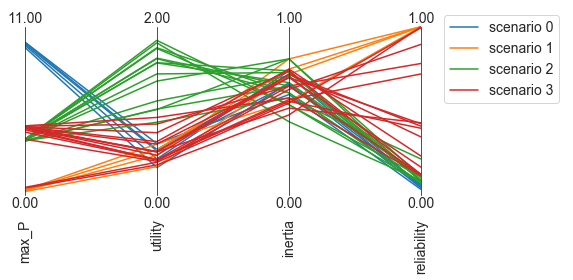

In [13]:
from ema_workbench.analysis import parcoords
import seaborn as sns
import matplotlib.pyplot as plt

colors = iter(sns.color_palette())

data = all_results[0].iloc[:, -4:]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 11
limits.loc[0, 'utility'] = 2
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, result in enumerate(all_results):
    color = next(colors)
    data = result.iloc[:, -4:]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()

It is of course unfair to compare the policy using just the results so far, because:
- The policies are optimized for different baseline scenarios
- The performance of the policies is calculated only based on a single scenario

Therefore, like in example 2, we re-evaluate them under deep uncertainty.

In [5]:
from ema_workbench import Policy

#first we store them into a list of policy objects
policies = []
for i, result in enumerate(all_results):
    result = result.iloc[:, :-4]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [6]:
#then we pass the list of policy objects to the evaluator

with MultiprocessingEvaluator(lake_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 38 policies * 1 model(s) = 38000 experiments
[MainProcess/INFO] 3800 cases completed
[MainProcess/INFO] 7600 cases completed
[MainProcess/INFO] 11400 cases completed
[MainProcess/INFO] 15200 cases completed
[MainProcess/INFO] 19000 cases completed
[MainProcess/INFO] 22800 cases completed
[MainProcess/INFO] 26600 cases completed
[MainProcess/INFO] 30400 cases completed
[MainProcess/INFO] 34200 cases completed
[MainProcess/INFO] 38000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [7]:
experiments, outcomes = reeevaluation_results

Next we evaluate their robustness. In this example we use the satisficing criterion as the robustness function.

In [8]:
import functools

#first we define the robustness function
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

For illustration, we use the following thresholds for each outcome variable:
- Maximum pollution should be smaller than 0.75
- Inertia should be larger than 0.6
- Reliability should be larger than 0.99
- Utility should be larger than 0.5

In [9]:
maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.5)

robustness_funcs = {"max_P": maxp,
                    "utility": utility,
                    "inertia": inertia,
                    "reliability": reliability}

The code below applies the robustness function to each policy.

In [10]:
overall_robustness = {}

for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness.sort_index(inplace=True)
overall_robustness

,inertia,max_P,reliability,utility
scenario 0 option 0,1.0,0.276,0.275,0.535
scenario 0 option 1,1.0,0.362,0.357,0.336
scenario 0 option 2,0.0,0.226,0.223,0.872
scenario 0 option 3,1.0,0.235,0.234,0.734
scenario 0 option 4,1.0,0.259,0.255,0.708
scenario 1 option 0,1.0,0.371,0.369,0.359
scenario 1 option 1,1.0,0.298,0.295,0.603
scenario 1 option 2,0.0,0.216,0.210,0.856
scenario 1 option 3,1.0,0.244,0.241,0.734
scenario 2 option 0,1.0,0.381,0.379,0.356


Finally, we plot the robustness scores. For simplifying visualization, we take only two optimized policies from each baseline scenario.

In [11]:
data_ = overall_robustness.copy()
data_['policy'] = data_.index

data = pd.DataFrame()

for s in range(4):
    data = data.append(data_.loc[[x.find('scenario {}'.format(s))>=0 for x in data_['policy'].values]].iloc[:2])
    
data = data.iloc[:, :-1]

We can now plot the robustness tradeoff

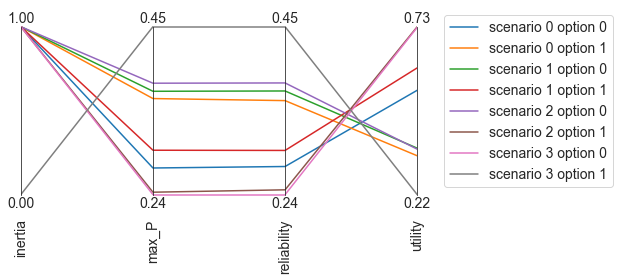

In [12]:
colors = sns.color_palette()

limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()